In [3]:
# UPDATE FOR NEW MONTH!
# Metric month. The mediawiki_history snapshot for this month must be available.
METRICS_MONTH_TEXT = "2019-06"
MEDIAWIKI_HISTORY_SNAPSHOT = "2019-06"

metrics_month = pd.Period(METRICS_MONTH_TEXT)
insert_start = str(metrics_month)
insert_end = str(metrics_month + 1)
graph_start = str(metrics_month - 48)

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from wmfdata import charting, hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
charting.set_mpl_style()

# Update table

In [4]:
create_cmd = Path("queries/create_editor_month.sql").read_text()
update_cmd = Path("queries/update_editor_month.sql").read_text().format(
    start=insert_start,
    end=insert_end,
    mwh_snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
)

hive.run(create_cmd)
hive.run(update_cmd)

# Quality checks

In [5]:
editors = hive.run("""
select
    month,
    count(*) as editors,
    sum(cast(content_edits >= 5 as int)) as active_editors,
    sum(cast(content_edits >= 100 as int)) as very_active_editors
from neilpquinn.editor_month 
group by month
order by month asc
limit 1000
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,active_editors,very_active_editors
month,,,
2019-02-01,392349,104090,15577
2019-03-01,415344,110508,16499
2019-04-01,390837,105405,15745
2019-05-01,404986,112687,16449
2019-06-01,372965,105245,15590


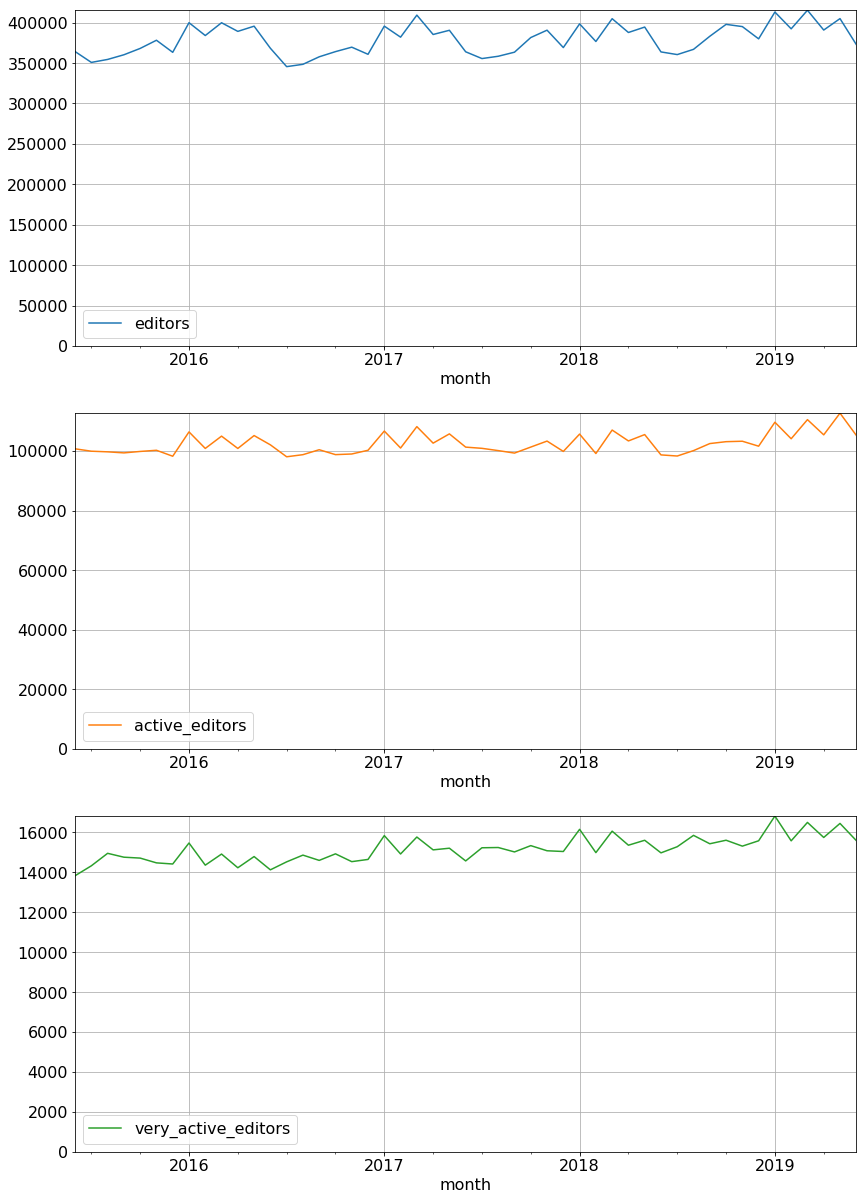

In [6]:
ax = editors[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 21),
    sharex=False
)

In [7]:
editors_per_wiki = hive.run("""
select
    month,
    wiki,
    count(*) as editors 
from neilpquinn.editor_month 
where
    wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by month, wiki
order by month, wiki
limit 10000
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2019-02-01,4432.0,20449.0,136246.0,2031.0,7846.0
2019-03-01,5043.0,20898.0,146209.0,2112.0,8913.0
2019-04-01,4668.0,19959.0,139292.0,2067.0,8498.0
2019-05-01,4946.0,20225.0,136621.0,2322.0,8585.0
2019-06-01,4256.0,19528.0,126296.0,2422.0,8368.0


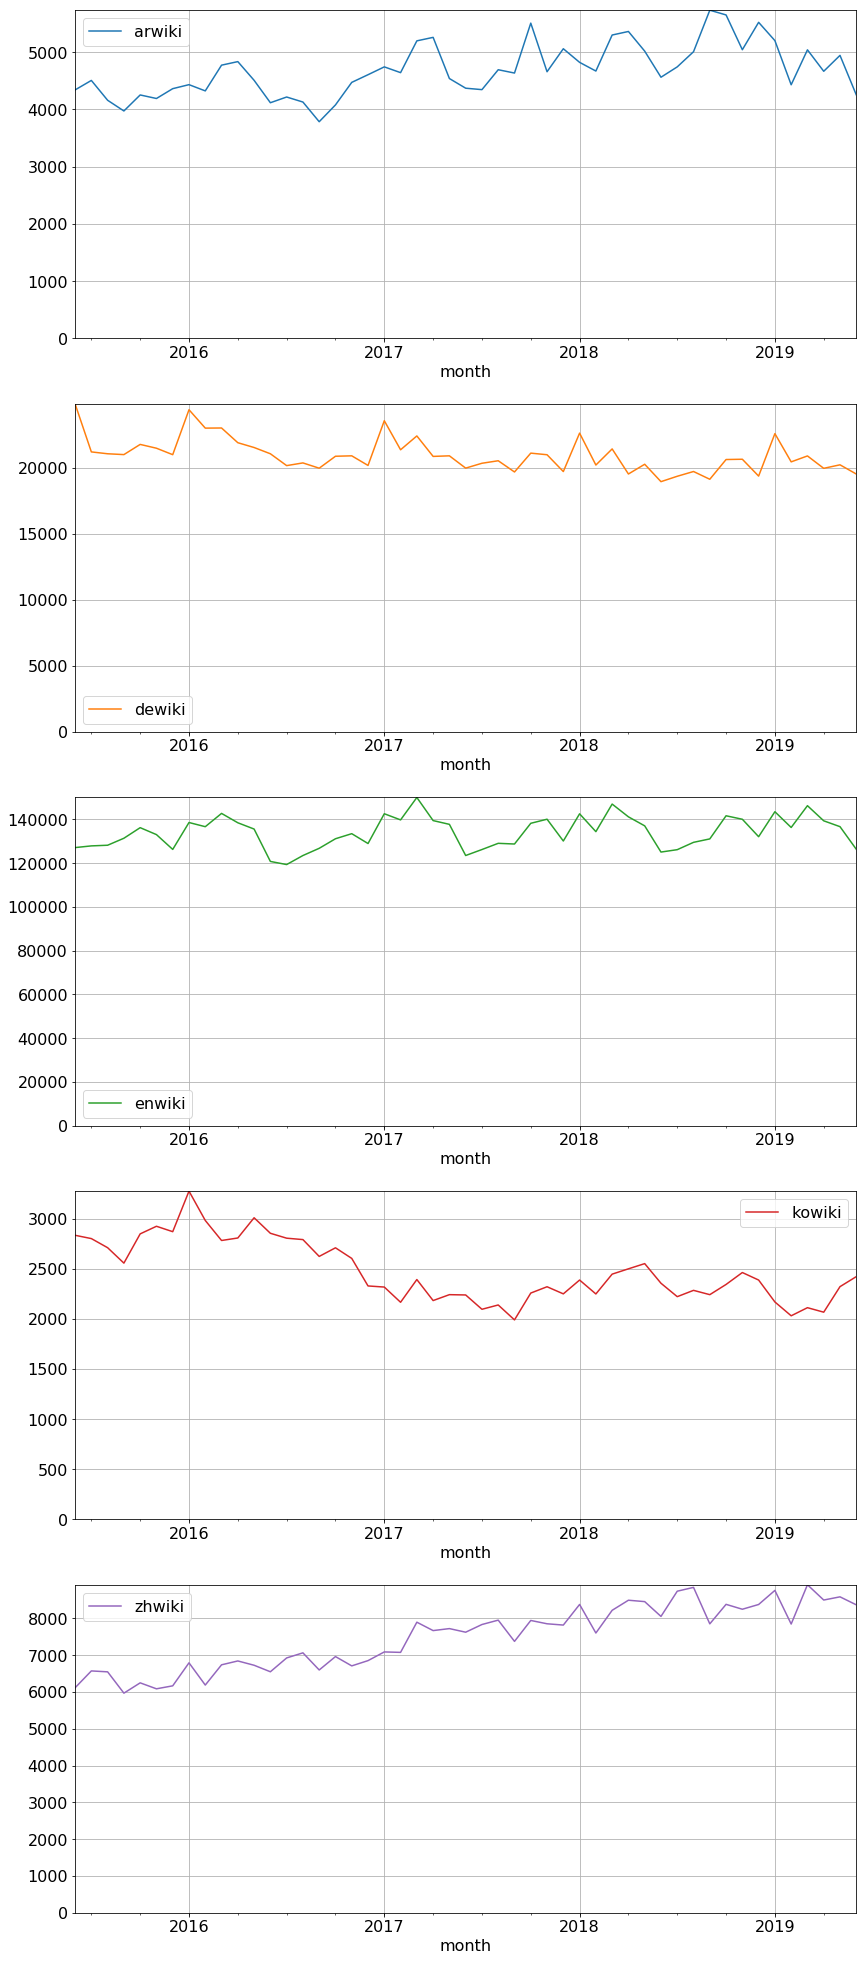

In [8]:
editors_per_wiki[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 35),
    sharex=False
);